In [271]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer,PolynomialFeatures
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,
AdaBoostClassifier)
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn import preprocessing, model_selection
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

%matplotlib inline

#set seed for reproducibility
np.random.seed(0) 
random_state = 42

In [213]:
#raw data
train = pd.read_csv('training_v2.csv')
test = pd.read_csv('unlabeled.csv.zip') #data without hopsital_death values (all nulls)

## Preprocessing for Training Dataset 

In [214]:
#Imputation for missing values for categorical variable 
cat = train.select_dtypes(include=['object']).apply(lambda x: x.fillna(x.value_counts().index[0]))

#Mean Encoding for categorical variables 
target = train['hospital_death']
cat1 = pd.concat([cat,target], axis=1, sort=False)
for header in cat1.columns:
    if header != 'hospital_death':
        means = cat1.groupby(header)['hospital_death'].mean()
        cat1[header] = cat1[header].map(means)

#Additive smoothing (regularization technique to avoid overfitting)
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

for header in cat1.columns:
    if header != 'hospital_death':
        cat1[header] = calc_smooth_mean(cat1, by=header, on='hospital_death', m=10)

#Imputation for missing values for numerical variable 
hosp_death = train['hospital_death']
data_nolabel = train.drop('hospital_death', axis=1)
num = data_nolabel.select_dtypes(include=['float64','int64'])
num = num.fillna(num.mean())

#putting back cat and num features together
imputed_train_data = pd.concat([num,cat1], axis=1, sort=False)

## Preprocessing for testing dataset 

In [277]:
#Imputation for missing values for categorical variable 
cat_test = test.select_dtypes(include=['object']).apply(lambda x: x.fillna(x.value_counts().index[0]))

#label encoding 
le = LabelEncoder()
for col in cat_test.columns:
    cat_test[col] = le.fit_transform(cat_test[col])
norm = pd.DataFrame(preprocessing.Normalizer().fit_transform(cat_test),columns=cat_test.columns)

#Imputation for missing values for numerical variable 
hosp_death_test = test['hospital_death']
data_nolabel_test = test.drop('hospital_death', axis=1)
num_test = data_nolabel_test.select_dtypes(include=['float64','int64'])
num_test = num_test.fillna(num_test.mean())

In [278]:
#putting back cat and num features together
imputed_test = pd.concat([num_test,norm], axis=1, sort=False)
x_testing = imputed_test.drop(['encounter_id', 'patient_id', 'hospital_id'], axis=1).copy()

## Final Dataset

In [279]:
final_data = imputed_train_data.sample(frac=1).reset_index(drop=True) #shuffle the data
x_training = final_data.drop(['encounter_id', 'patient_id', 'hospital_id','hospital_death'], axis=1).copy()
y_training = final_data['hospital_death']

#Over Sampling to solve output class imbalance problem
# sm = SMOTE(random_state=random_state)
# X_training, y_trainings = sm.fit_sample(x_training,y_training)

# X_train = x_training.copy()
# y_train = y_training.copy()
# X_test = x_testing.copy()

#Data Partition
X_train, X_test, y_train, y_test = train_test_split(x_training, y_training,test_size = 0.2, random_state=random_state)

## Model Building 

In [281]:
%%time
classifiers = [LGBMClassifier(), 
               XGBClassifier()]
log_cols=["Classifier", "Accuracy","AUC"]
result = pd.DataFrame(columns=log_cols)
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prob = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, prob)
    log_entry = pd.DataFrame([[name, acc*100, auc]],columns=log_cols)
    result = result.append(log_entry)
result

CPU times: user 1min 11s, sys: 771 ms, total: 1min 11s
Wall time: 59.4 s


,Classifier,Accuracy,AUC
0,LGBMClassifier,93.239928,0.901132
0,XGBClassifier,93.103636,0.895888


## Final Prediction

In [240]:
classifiers = [LGBMClassifier()]
for clf in classifiers:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)[:,1]
encounter_id = pd.DataFrame(test['encounter_id'])
prob1 = pd.DataFrame(prob).rename(columns = {0: 'hospital_death'})
output = pd.concat([encounter_id,prob1], axis=1, sort=False)
output.to_csv('DSDJ1.5.csv', header=True, index=False)

## Cross Validation

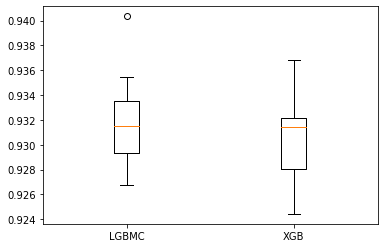

In [250]:
#Cross validation
models = []
models.append(('LGBMC', LGBMClassifier()))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=random_state)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    (msg)
# boxplot algorithm comparison
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Model Tuning

In [272]:
%%time
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'} 
# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501],
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3,
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])
# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 6, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.9136981671963669


## Final Model after tuning 

In [ ]:
%%time
classifiers = [LGBMClassifier(boosting_type='gbdt',
                              colsample_bytree=0.65, 
                              learning_rate=0.005, 
                              n_estimators = 40,
                              num_leaves=6, 
                              objective='binary', 
                              random_state=501, 
                              reg_alpha=1, 
                              reg_lambda=1, 
                              subsample=0.7), 
               XGBClassifier()]
log_cols=["Classifier", "Accuracy","AUC"]
result = pd.DataFrame(columns=log_cols)
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prob = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, prob)
    log_entry = pd.DataFrame([[name, acc*100, auc]],columns=log_cols)
    result = result.append(log_entry)
result